In [2]:
import numpy as np
import polars as pl
from data_io.loader.data_loader import DataLoader
import matplotlib.pyplot as plt
import seaborn as sns
import matplotlib.pyplot as plt
import polars as pl

dl = DataLoader()

Holidays folder not found: ./data/processed/holidays/


In [3]:
stations = dl.get_bicyle_stations()

df_list = []
for station in stations:
    temp_obj = dl.get_bicycle(station, sample_rate="1h")
    temp_df = temp_obj.df.select([
        pl.col("datetime").alias("time"),
        pl.col("channels_all").alias("count"),
        pl.lit(station).alias("station_name")
    ])
    df_list.append(temp_df)

df = pl.concat(df_list)

df = df.filter(pl.col("station_name") != "Ernst-Walz-Brücke West - alt")

df_pivot = (df
    .pivot(
        values="count", 
        index="time", 
        columns="station_name", 
        aggregate_function="sum"
    )
    .sort("time")
)

corr_matrix = df_pivot.select(pl.all().exclude("time")).corr()
stations_labels = df_pivot.select(pl.all().exclude("time")).columns

/var/folders/27/bgwyvysx4qgchbx7ng_h34j80000gn/T/ipykernel_2487/2511104702.py:18: DeprecationWarning: the argument `columns` for `DataFrame.pivot` is deprecated. It was renamed to `on` in version 1.0.0.
  .pivot(


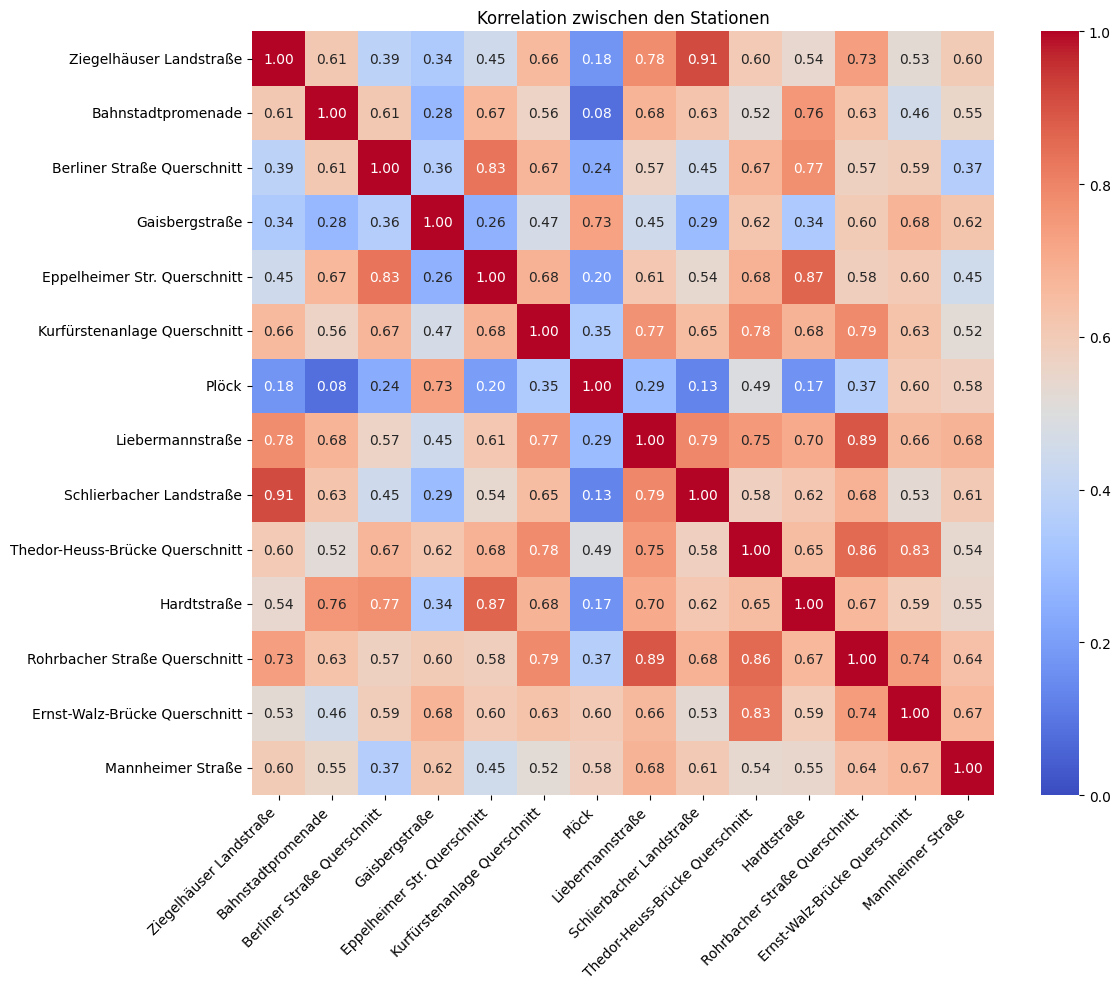

In [4]:
plt.figure(figsize=(12, 10))
sns.heatmap(
    corr_matrix, 
    xticklabels=stations_labels,
    yticklabels=stations_labels,
    annot=True,
    fmt=".2f",
    cmap="coolwarm",
    vmin=0, vmax=1 
)
plt.title("Korrelation zwischen den Stationen")
plt.xticks(rotation=45, ha="right")
plt.tight_layout()
plt.show()

In [2]:
loader = DataLoader()

# Display available stations
print("Available stations:")
for station in loader.get_bicyle_stations():
    print(f"  - {station}")

Available stations:
  - Ziegelhäuser Landstraße
  - Bahnstadtpromenade
  - Berliner Straße Querschnitt
  - Gaisbergstraße
  - Eppelheimer Str. Querschnitt
  - Kurfürstenanlage Querschnitt
  - Plöck
  - Ernst-Walz-Brücke West - alt
  - Liebermannstraße
  - Schlierbacher Landstraße
  - Thedor-Heuss-Brücke Querschnitt
  - Hardtstraße
  - Rohrbacher Straße Querschnitt
  - Ernst-Walz-Brücke Querschnitt
  - Mannheimer Straße


In [3]:
# Plot the difference between in and out channels
# This shows directional flow patterns (e.g., commute directions)

from plotly.subplots import make_subplots
import plotly.graph_objects as go

for station_name in loader.get_bicyle_stations():
    # Get daily data for the full available range
    data = loader.get_bicycle(station_name, sample_rate="1d")
    data = data.df
    
    # Calculate the difference between in and out channels
    data = data.with_columns([
        (pl.col('channels_in') - pl.col('channels_out')).alias('daily_diff')
    ])
    
    # Get data for plotting
    dates = data.select('datetime').to_series().to_list()
    data_diff = data.select('daily_diff').to_series().to_numpy()
    data_all = data.select('channels_all').to_series().to_numpy()
    
    n = len(data_diff)
    
    # smoothing window: 24 days if available, otherwise a small window
    window = 24 if n >= 24 else max(3, n // 10)
    smoothed_diff = np.convolve(data_diff, np.ones(window) / window, mode='same')
    smoothed_all = np.convolve(data_all, np.ones(window) / window, mode='same')
    
    # Create interactive plot with Plotly using secondary y-axis
    fig = make_subplots(specs=[[{"secondary_y": True}]])
    
    # Raw data (diff) - on secondary axis (linear)
    fig.add_trace(go.Scatter(
        x=dates,
        y=data_diff,
        mode='lines',
        name='raw (daily diff)',
        line=dict(color='gray', width=0.5),
        opacity=0.25,
        hovertemplate='<b>Date:</b> %{x}<br><b>Daily Diff:</b> %{y}<extra></extra>'
    ), secondary_y=False)
    
    # Smoothed diff - on secondary axis (linear)
    fig.add_trace(go.Scatter(
        x=dates,
        y=smoothed_diff,
        mode='lines',
        name=f'{window}-day MA (daily diff [in-out])',
        line=dict(color='#1f77b4', width=2),
        hovertemplate='<b>Date:</b> %{x}<br><b>Smoothed Diff:</b> %{y:.1f}<extra></extra>'
    ), secondary_y=False)
    
    # Smoothed all channels - on primary axis (log scale)
    fig.add_trace(go.Scatter(
        x=dates,
        y=smoothed_all,
        mode='lines',
        name=f'{window}-day MA (all channels [in+out])',
        line=dict(color='#d62728', width=2),
        hovertemplate='<b>Date:</b> %{x}<br><b>Smoothed All:</b> %{y:.1f}<extra></extra>'
    ), secondary_y=True)
    
    fig.update_layout(
        title=f'Cycle Counter Data for {station_name}<br>from {dates[0]} to {dates[-1]}',
        xaxis_title='Date',
        height=500,
        width=1400,
        hovermode='x unified',
        legend=dict(x=0, y=1, orientation='h')
    )
    
    # Set y-axes titles
    fig.update_yaxes(title_text="Daily Difference (In - Out)", secondary_y=False)
    fig.update_yaxes(title_text="Total Channels (In + Out)", secondary_y=True)
    
    fig.show()